In [6]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
import sqlite3
conn = sqlite3.connect("stock.sqlite")
query = "select * from stock_table_d where `ticker` == 'AAPL' and datetime > '2012-01-01' and datetime < '2021-01-01'"
df = pd.read_sql(query,conn)
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2013-02-13 00:00:00,16.686071,16.915714,16.543571,16.678928,14.405273,475207600,AAPL
1,2013-02-14 00:00:00,16.590000,16.844286,16.572144,16.663929,14.392323,355275200,AAPL
2,2013-02-15 00:00:00,16.744642,16.791430,16.425714,16.434286,14.193980,391745200,AAPL
3,2013-02-19 00:00:00,16.467857,16.526072,16.208929,16.428213,14.188737,435783600,AAPL
4,2013-02-20 00:00:00,16.346071,16.346071,16.028570,16.030357,13.845119,476302400,AAPL
...,...,...,...,...,...,...,...,...
1981,2020-12-24 00:00:00,131.320007,133.460007,131.100006,131.970001,130.205765,54930100,AAPL
1982,2020-12-28 00:00:00,133.990005,137.339996,133.509995,136.690002,134.862671,124486200,AAPL
1983,2020-12-29 00:00:00,138.050003,138.789993,134.339996,134.869995,133.067001,121047300,AAPL
1984,2020-12-30 00:00:00,135.580002,135.990005,133.399994,133.720001,131.932388,96452100,AAPL


In [7]:
df.shape

(1986, 8)

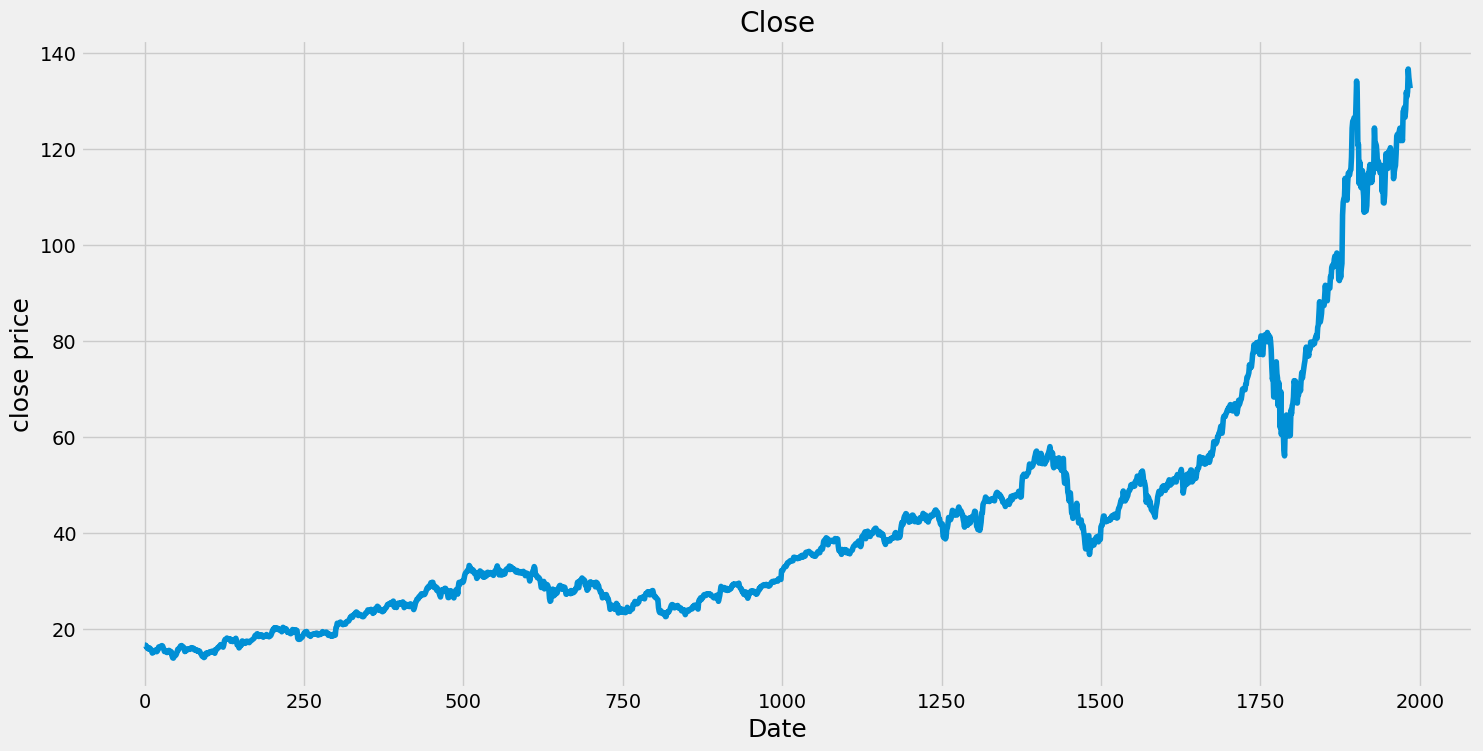

In [8]:
plt.figure(figsize=(16,8))
plt.title('Close')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('close price',fontsize=18)
plt.show()